# How to test RAG 


**VoyageAI** is a powerful tool designed for creating and managing high-quality embeddings for use in machine learning and AI applications. Embeddings are vector representations of data, such as text, images, or other entities, that capture their meaning or features in a numerical format. These embeddings are crucial for tasks like semantic search, recommendation systems, natural language processing (NLP), and clustering, where understanding relationships between entities is key.

VoyageAI offers a streamlined process for generating embeddings using advanced machine learning models, including transformers and neural networks. These models take raw input data, like text or image content, and produce dense vectors that encode semantic or contextual information. For example, in a text embedding, similar sentences or words will have vector representations that are closer together in the embedding space.

One of the standout features of VoyageAI is its ability to integrate seamlessly with a variety of machine learning workflows. It provides APIs and tools that allow developers to generate embeddings at scale, store them efficiently, and retrieve them for downstream applications. Whether you're building a semantic search engine or training a recommendation system, VoyageAI simplifies the process of embedding generation and management.

VoyageAI also emphasizes ease of use and scalability. It is designed to handle large datasets, making it suitable for enterprise-level applications. The platform supports cloud-based operations, ensuring that the embedding processes are fast and reliable, even when dealing with massive amounts of data.

Additionally, VoyageAI aligns well with vector databases, where embeddings are stored and queried. This allows developers to combine the embedding generation capabilities of VoyageAI with vector search technologies to build end-to-end solutions for searching, retrieving, and analyzing data based on similarity or context.


In [14]:
import voyageai
from dotenv import load_dotenv
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os


The **Stanford Question Answering Dataset (SQuAD)** is a widely-used benchmark dataset for training and evaluating machine learning models in the field of natural language processing (NLP), specifically for **question answering (QA)** tasks. It was created by researchers at Stanford University and has become a gold standard for building QA systems.

SQuAD consists of a collection of questions and corresponding answers, paired with context passages extracted from Wikipedia articles. Each question is designed to be answered based on the content of its associated passage. The answers are not standalone but are **spans of text** directly taken from the context. For instance, if the context is, "Hugging Face is an AI company creating tools for natural language processing," and the question is, "What does Hugging Face create?" the answer would be "tools for natural language processing."

One of the key characteristics of SQuAD is that it contains **human-written questions**. These questions are crafted to be natural, mimicking how a person would ask something about a given passage. This makes it particularly valuable for training models that aim to handle real-world QA scenarios.

The dataset is typically divided into two main subsets: a **training set** for building and fine-tuning machine learning models and a **validation set** for evaluating performance. There are multiple versions of SQuAD, including SQuAD 1.1, which only contains questions with direct answers in the passage, and SQuAD 2.0, which includes unanswerable questions to test a model's ability to handle cases where no answer exists in the context.

SQuAD is used to benchmark NLP models by assessing their ability to understand text and locate precise answers. Success on SQuAD is often measured using metrics like **Exact Match (EM)**, which calculates the percentage of predictions that exactly match the ground truth, and **F1-score**, which considers both precision and recall.

Overall, SQuAD has significantly advanced the development of QA systems and serves as a cornerstone for evaluating progress in NLP tasks.

In [2]:
from datasets import load_dataset

In [3]:
# Load environment variables from the .env file
load_dotenv()

# Access environment variables
VO_API_KEY = os.getenv('VO_API_KEY')

In [5]:
# Load a dataset for testing (e.g., Natural Questions for QA tasks)
dataset = load_dataset("squad", split="train[:1000]")  # First 100 samples

I filtered the dataset to keep only unique contexts because I want to test how accurate my Retrieval-Augmented Generation (RAG) system is. By removing duplicates, I simplified the dataset, which makes it much easier to evaluate the system’s performance.

The idea is straightforward: if each context in the dataset is unique, I can clearly see whether the retrieval component of the RAG model selects the right context and whether the generation part uses it correctly to answer the question. With duplicate contexts, this would be harder to assess because repeated data could skew the results.

This also helps me analyze the results more effectively. A smaller, cleaner dataset means I can spot issues or unexpected behaviors quickly, without having to wade through redundant data. Plus, it saves resources since I don’t need to process unnecessary duplicates.


In [6]:

# Create a set to track unique contexts and filter the dataset
unique_contexts = set()
filtered_samples = []

for sample in dataset:
    context = sample['context']
    if context not in unique_contexts:  # Check if context is unique
        unique_contexts.add(context)   # Add context to the set
        filtered_samples.append(sample)  # Keep the sample

# Display filtered dataset
print(f"Original dataset size: {len(dataset)}")
print(f"Filtered dataset size: {len(filtered_samples)}")

# Example: Inspect the first sample from the filtered dataset
if filtered_samples:
    sample = filtered_samples[0]
    print("\nExample Record:")
    print("Context:", sample['context'])
    print("Question:", sample['question'])
    print("Answer Text:", sample['answers']['text'])
    print("Answer Start Index:", sample['answers']['answer_start'])
else:
    print("No unique contexts found!")


Original dataset size: 1000
Filtered dataset size: 119

Example Record:
Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer Text: ['Saint Bernadette Soubirous']
Answer Start Index: [515]


In [7]:
filtered_samples

[{'id': '5733be284776f41900661182',
  'title': 'University_of_Notre_Dame',
  'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
  'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
  'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}},
 {'id': '5733bf84d058e614000b61be',
  'title

In [9]:
vo = voyageai.Client(api_key=VO_API_KEY)

In [10]:
context_embeddings = []
query_embeddings = []

for sample in filtered_samples:
    print("Context:", sample['context'])
    print("Question:", sample['question'])
    context_embeddings.append(vo.embed(sample['context'], model="voyage-3", input_type="document").embeddings[0])
    query_embeddings.append(vo.embed(sample['question'], model="voyage-3", input_type="document").embeddings[0])


Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Context: As at most other universities, Notre Dame's students run a number of news media outlets. The nine student-run outlets include three newspapers, both a radio and television station, and several magazines a

In [11]:
len(context_embeddings)

119

In [12]:
len(query_embeddings)

119

Now in the next snippet I compute **cosine similarities** between two sets of embeddings: one representing the queries (questions) and the other representing the contexts (content). The goal here is to measure how similar each query is to every context in the dataset, based on their embeddings.

The idea is that in our dataset, we have a set of **questions** and a set of **contexts** (or passages of text). These questions and contexts have been converted into numerical embeddings, which are dense vector representations capturing their semantic meaning. The cosine similarity measure allows us to compare these vectors to determine how closely they are related.

Cosine similarity is particularly useful here because it focuses on the angle between the vectors rather than their magnitude. This means that even if two embeddings are scaled differently, cosine similarity will still capture the alignment between their directions, which reflects their semantic similarity.

The result of this computation is a **similarity matrix**, where:
- Each row corresponds to a query (question).
- Each column corresponds to a context (content).
- Each value in the matrix represents the cosine similarity score between a specific query and a specific context.

For example, if you have 5 questions and 10 contexts, the resulting matrix will have 5 rows and 10 columns. Each value in this matrix tells you how closely a given question is related to a particular context, with scores ranging from -1 (completely dissimilar) to 1 (identical or perfectly aligned).

This matrix is essential for the next step in the process. By analyzing the similarity scores, we can determine which context is the most relevant for a given question. This is the foundation of a **retrieval** step in Retrieval-Augmented Generation (RAG) systems, where the goal is to match queries with the most appropriate contexts before generating an answer.

A dense vector embedding is a numerical representation of data, like text, images, or other entities, in a way that captures their meaning or important features. The idea is to take something complex, like a sentence, and turn it into a fixed-size vector (a list of numbers). These vectors are called "dense" because every dimension in the vector contains some meaningful value, unlike sparse vectors, where most values are zeros.

In [ ]:
# Example data: context and query embeddings
# context_embeddings and query_embeddings should be numpy arrays
# For simplicity, assume they are already computed
# context_embeddings.shape = (num_contexts, embedding_dim)
# query_embeddings.shape = (num_queries, embedding_dim)


# Correct indices: by definition, the correct context for query[i] is context[i]
correct_indices = list(range(len(query_embeddings)))

Cosine similarity is a mathematical measure that calculates the similarity between two vectors based on the cosine of the angle between them in a multidimensional space. It is commonly used in text and data analysis to measure the similarity between two entities, such as word embeddings, sentence embeddings, or other feature representations.

### Formula
The formula for cosine similarity between two vectors $ \mathbf{A} $ and $ \mathbf{B} $ is:

$$
\text{cosine\_similarity}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
$$

Where:
- $ \mathbf{A} \cdot \mathbf{B} $ is the dot product of vectors $ \mathbf{A} $ and $ \mathbf{B} $, calculated as:
  $$
  \mathbf{A} \cdot \mathbf{B} = \sum_{i=1}^{n} A_i B_i
  $$
  where $ A_i $ and $ B_i $ are the $ i $-th components of vectors $ \mathbf{A} $ and $ \mathbf{B} $.

- $ \|\mathbf{A}\| $ is the magnitude (or Euclidean norm) of vector $ \mathbf{A} $, calculated as:
  $$
  \|\mathbf{A}\| = \sqrt{\sum_{i=1}^{n} A_i^2}
  $$

- $ \|\mathbf{B}\| $ is the magnitude of vector $ \mathbf{B} $, calculated similarly:
  $$
  \|\mathbf{B}\| = \sqrt{\sum_{i=1}^{n} B_i^2}
  $$

### Simplified Explanation
Cosine similarity measures how aligned two vectors are:
1. The **dot product** captures the similarity in direction.
2. Dividing by the magnitudes $ \|\mathbf{A}\| \|\mathbf{B}\| $ ensures the result is normalized to the range $[-1, 1]$, regardless of the scale of the vectors.

- **1** indicates that the vectors point in exactly the same direction (maximum similarity).
- **0** means the vectors are orthogonal (no similarity).
- **-1** indicates the vectors point in opposite directions (complete dissimilarity).

### Example
For two vectors $ \mathbf{A} = [1, 2, 3] $ and $ \mathbf{B} = [4, 5, 6] $:
1. Calculate the dot product:
   $$
   \mathbf{A} \cdot \mathbf{B} = 1 \cdot 4 + 2 \cdot 5 + 3 \cdot 6 = 4 + 10 + 18 = 32
   $$
2. Calculate the magnitudes:
   $$
   \|\mathbf{A}\| = \sqrt{1^2 + 2^2 + 3^2} = \sqrt{1 + 4 + 9} = \sqrt{14}
   $$
   $$
   \|\mathbf{B}\| = \sqrt{4^2 + 5^2 + 6^2} = \sqrt{16 + 25 + 36} = \sqrt{77}
   $$
3. Compute cosine similarity:
   $$
   \text{cosine\_similarity}(\mathbf{A}, \mathbf{B}) = \frac{32}{\sqrt{14} \cdot \sqrt{77}} \approx 0.974
   $$

Cosine similarity quantifies how similar $ \mathbf{A} $ and $ \mathbf{B} $ are in terms of direction, making it highly effective for tasks like semantic similarity and clustering.

In [16]:
# Compute cosine similarities between queries and all contexts
similarity_matrix = cosine_similarity(query_embeddings, context_embeddings)

In [17]:
similarity_matrix

array([[0.56908421, 0.16628699, 0.38734379, ..., 0.19421843, 0.28180293,
        0.25452309],
       [0.40347728, 0.49713463, 0.4858703 , ..., 0.22083078, 0.28917713,
        0.24076359],
       [0.49206285, 0.17539607, 0.54876892, ..., 0.19992978, 0.23236543,
        0.27031041],
       ...,
       [0.22270523, 0.12018819, 0.20521925, ..., 0.49710005, 0.51410639,
        0.41778762],
       [0.25045997, 0.1492192 , 0.22500756, ..., 0.46632876, 0.56167292,
        0.41155648],
       [0.26843113, 0.10177235, 0.24945589, ..., 0.32987987, 0.32804385,
        0.62822034]])

The purpose of this line is to identify which context from the dataset is the most similar to each query based on the **cosine similarity scores** we computed earlier. The `similarity_matrix` contains a score for every query-context pair, where higher scores mean greater similarity. By using `np.argmax` along `axis=1`, we find the index of the highest similarity score for each query.

We do this because, for every query, we need to retrieve the **best-matching context**—the one most likely to contain the relevant information or answer. The result, `retrieved_indices`, gives us a list of indices, where each index corresponds to the most relevant context for a specific query. This is a crucial step in the retrieval process for systems like RAG because it ensures we’re pairing each query with the context that has the highest semantic alignment.

In [18]:

# Find the index of the most similar context for each query
retrieved_indices = np.argmax(similarity_matrix, axis=1)

# Compare retrieved indices with correct indices
accuracy = np.mean([retrieved == correct for retrieved, correct in zip(retrieved_indices, correct_indices)])

# Optional: Analyze results
for i, (query_idx, retrieved_idx, correct_idx) in enumerate(zip(range(len(query_embeddings)), retrieved_indices, correct_indices)):
    print(f"Query {i}: Retrieved Index = {retrieved_idx}, Correct Index = {correct_idx}, Match = {retrieved_idx == correct_idx}")


Query 0: Retrieved Index = 0, Correct Index = 0, Match = True
Query 1: Retrieved Index = 38, Correct Index = 1, Match = False
Query 2: Retrieved Index = 2, Correct Index = 2, Match = True
Query 3: Retrieved Index = 3, Correct Index = 3, Match = True
Query 4: Retrieved Index = 4, Correct Index = 4, Match = True
Query 5: Retrieved Index = 35, Correct Index = 5, Match = False
Query 6: Retrieved Index = 6, Correct Index = 6, Match = True
Query 7: Retrieved Index = 7, Correct Index = 7, Match = True
Query 8: Retrieved Index = 8, Correct Index = 8, Match = True
Query 9: Retrieved Index = 38, Correct Index = 9, Match = False
Query 10: Retrieved Index = 38, Correct Index = 10, Match = False
Query 11: Retrieved Index = 11, Correct Index = 11, Match = True
Query 12: Retrieved Index = 12, Correct Index = 12, Match = True
Query 13: Retrieved Index = 37, Correct Index = 13, Match = False
Query 14: Retrieved Index = 27, Correct Index = 14, Match = False
Query 15: Retrieved Index = 38, Correct Index 

In [19]:
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 43.70%


I ran my test, and the results showed that the accuracy of the model was lower than expected. This isn't entirely surprising given the strategy we used for retrieval in this experiment. Specifically, we chose only the **single most similar vector** (the one with the highest cosine similarity to the query) to provide the context for answering the query. While this approach seems logical at first, it may not be the best strategy, especially for datasets where the most relevant context might not always rank first.

The issue here is that the retrieval model, while generally accurate, might sometimes rank the truly relevant context second, third, or even lower. By restricting ourselves to just the top-ranked vector, we miss the opportunity to consider these slightly lower-ranked contexts, which could still contain critical information for answering the query. This means we might be unfairly penalizing the system's overall accuracy.

To explore this further, I want to extend the strategy by taking into account not just the first vector but also the **second, third, and so on**. The idea is to retrieve a set of top-k similar contexts (e.g., the top 3 or top 5) for each query and then evaluate the accuracy based on whether the correct context is present in this set. This would allow us to analyze how often the relevant context is within the top-k results and whether including more candidates improves the system's performance.

By doing this, I can better understand the limitations of using only the top-ranked vector and explore whether a broader retrieval strategy improves results. It might also reveal insights into how well the similarity scores reflect true relevance and whether fine-tuning the retrieval model or embeddings could further enhance accuracy.


In [20]:
import matplotlib.pyplot as plt

# Function to compute Recall@k
def recall_at_k(similarity_matrix, correct_indices, k):
    top_k_indices = np.argsort(-similarity_matrix, axis=1)[:, :k]  # Get top-k indices
    hits = [int(correct in top_k) for correct, top_k in zip(correct_indices, top_k_indices)]
    recall = np.mean(hits)  # Fraction of correct contexts found in the top-k
    return recall

# Evaluate Recall@k for various k values
k_values = list(range(1, 11))  # Test for k=1 to k=10
recall_scores = [recall_at_k(similarity_matrix, correct_indices, k) for k in k_values]

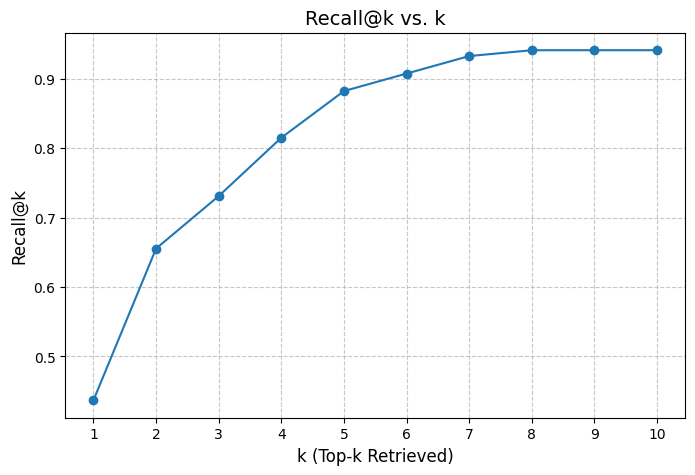

In [21]:

# Plot Recall@k
plt.figure(figsize=(8, 5))
plt.plot(k_values, recall_scores, marker='o')
plt.title("Recall@k vs. k", fontsize=14)
plt.xlabel("k (Top-k Retrieved)", fontsize=12)
plt.ylabel("Recall@k", fontsize=12)
plt.xticks(k_values)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

The results show that as we increase the number of top-k neighbors considered (k), the accuracy improves. This means that when we look at more potential matches (e.g., top 2, top 3, etc.), the chance of including the correct context increases. 

However, this improvement only continues up to a certain point. Around \( k = 8 \), the recall levels off at 94.1%, meaning adding more neighbors doesn’t provide any additional benefit. This indicates that the correct context is almost always found within the top-8 results, and retrieving more candidates after that just adds unnecessary noise without improving accuracy.

In short, increasing \( k \) helps make the results more accurate, but only up to a certain threshold. Beyond that, it’s better to balance efficiency and performance rather than simply retrieving more neighbors.